In [26]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tokens import FullTokenizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_recall_fscore_support
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import statistics
from statistics import mode
import matplotlib.pyplot as plt
import pickle
from torchsummary import summary

In [2]:
def string_to_list(input_string: str) -> list:
    res = input_string.strip('][')
    res = res.replace('"', '')
    res = res.split(', ')
    
    return res

In [3]:
def my_filter(row):
    for label in row["reiss"]:
        if label == 'na':
            return False

    return True
    
def preprocess(file, bert_layer, only_a_few=False):
    file = file[file['action'] != 'no']
    file = file[file['motivation'] != 'none']
    file = file[file['maslow'] != '[]']
    file = file[file['reiss'] != '[]']
    file = file[file['reiss'] != '["na"]']
    file["maslow"] = file["maslow"].apply(string_to_list)
    file["reiss"] = file["reiss"].apply(string_to_list)
    file = file[file.apply(my_filter, axis=1)]
    file.reset_index(drop=True, inplace=True)

    vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
    do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
    tokenizer = FullTokenizer(vocab_file, do_lower_case)

    mlb_m = MultiLabelBinarizer()
    labels_m = mlb_m.fit_transform(file["maslow"])

    mlb_r = MultiLabelBinarizer()
    labels_r = mlb_r.fit_transform(file["reiss"])

    labels = np.concatenate((labels_m, labels_r), axis=1)

    data = bert_encode(file['sentence'].values, tokenizer, only_a_few=only_a_few)

    if only_a_few:
        o_labels = labels[0:32, :]
        return data, o_labels

    return data, labels

In [96]:
training_file_motivation = pd.read_csv(os.path.join("data/dev/motivation", "allcharlinepairs_noids.csv"))
testing_file_motivation = pd.read_csv(os.path.join("data/test/motivation", "allcharlinepairs_noids.csv"))

In [239]:
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [237]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=128, only_a_few=False):
    all_tokens = []
    all_masks = []
    all_segments = []

    j = 0
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        

        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

        j += 1
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [7]:
def build_model(bert_layer, max_len=128):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(5, activation='sigmoid')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [11]:
train_input, train_labels = preprocess(training_file_motivation, bert_layer)
test_input, test_labels = preprocess(testing_file_motivation, bert_layer)

In [14]:
model = build_model(bert_layer, max_len=128)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',         

/usr/local/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [34]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_history = model.fit(
    train_input, train_labels, 
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1
)

Epoch 1/3
256/718 [=========>....................] - ETA: 12:17:17 - loss: 2.0168 - accuracy: 0.3302

In [19]:
model.load_weights('model1.h5')

In [112]:
lists = np.array([True] * 47554 + [False])

training_file_motivation[lists]

,storyid,linenum,char,context,sentence,action,motivation,maslow,reiss
0,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,1,I (myself),NaN,I began making fish curry for my boyfriend and I.,yes,eat some food,"[""physiological""]","[""food""]"
1,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,1,I (myself),NaN,I began making fish curry for my boyfriend and I.,yes,to be nice,"[""love"", ""physiological""]","[""family"", ""romance"", ""food""]"
2,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,1,I (myself),NaN,I began making fish curry for my boyfriend and I.,yes,to satisfy a craving.,"[""physiological""]","[""food""]"
3,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,1,Boyfriend,NaN,I began making fish curry for my boyfriend and I.,no,"[""none""]","[""none""]","[""none""]"
4,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,2,I (myself),I began making fish curry for my boyfriend and I.,I decided not to read a recipe since I've made...,yes,to help out,"[""spiritual growth""]","[""indep""]"
...,...,...,...,...,...,...,...,...,...
47549,2aa1aca3-9264-4e27-9ebb-fa5de8e7e84e,4,Crab,Marcus was collecting shells on the beach.|He ...,Suddenly he felt a sharp pinch.,no,"[""none""]","[""none""]","[""none""]"
47550,2aa1aca3-9264-4e27-9ebb-fa5de8e7e84e,5,Marcus,Marcus was collecting shells on the beach.|He ...,A crab was inside the shell pinching his leg.,yes,to have collection of shells,"[""spiritual growth""]","[""curiosity""]"
47551,2aa1aca3-9264-4e27-9ebb-fa5de8e7e84e,5,Marcus,Marcus was collecting shells on the beach.|He ...,A crab was inside the shell pinching his leg.,yes,to collect things,"[""spiritual growth""]","[""curiosity""]"
47552,2aa1aca3-9264-4e27-9ebb-fa5de8e7e84e,5,Marcus,Marcus was collecting shells on the beach.|He ...,A crab was inside the shell pinching his leg.,yes,none,"[""none""]",[]


In [31]:
test_output = model.predict(test_input)
test_output = np.rint(test_output)

print(test_output.shape)
print(test_labels.shape)

precision_recall_fscore_support(test_labels, test_output, average='micro')

(32, 5)
(32, 5)


(0.4074074074074074, 0.2619047619047619, 0.3188405797101449, None)

In [45]:
class TextCNN(object):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    """
    def __init__(
      self, sequence_length, num_classes, vocab_size,
      embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):

        # Placeholders for input, output and dropout
        #self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_x = tf.Variable(tf.ones(shape = [sequence_length]), dtype=tf.float32)
        #self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.input_y = tf.Variable(tf.ones(shape = [num_classes], dtype=tf.float32))
        #self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")
        self.dropout_keep_prob = tf.Variable(tf.ones(1), dtype = tf.float32)

        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)

        # Embedding layer
        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            self.W = tf.Variable(
                tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),
                name="W")
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

        # Create a convolution + maxpool layer for each filter size
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(
                    self.embedded_chars_expanded,
                    W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                # Maxpooling over the outputs
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])

        # Add dropout
        with tf.name_scope("dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)

        # Final (unnormalized) scores and predictions
        with tf.name_scope("output"):
            W = tf.get_variable(
                "W",
                shape=[num_filters_total, num_classes],
                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")

        # Calculate mean cross-entropy loss
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        # Accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

In [24]:
class CNN_Text(nn.Module):
    
    def __init__(self, args):
        super(CNN_Text, self).__init__()
        print(args)
        self.args = args
        
        V = args['embed_num']
        D = args['embed_dim']
        C = args['class_num']
        Ci = 1
        Co = args['kernel_num']
        Ks = args['kernel_sizes']

        # V -> number of embeddings -> 128, sentence_size
        # D -> embedding dimension -> 768, bert output size
        # W

        #self.embed = nn.Embedding(V, D)
        self.convs = nn.ModuleList([nn.Conv2d(Ci, Co, (K, D)) for K in Ks])
        self.dropout = nn.Dropout(args['dropout'])
        self.fc1 = nn.Linear(len(Ks) * Co, C)

        if self.args['static']:
            self.embed.weight.requires_grad = False

    def forward(self, x):
        #x = self.embed(x)  # (N, W, D)
    
        x = x.unsqueeze(1)  # (N, Ci, W, D)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]  # [(N, Co, W), ...]*len(Ks)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)

        x = torch.cat(x, 1)

        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        return logit

In [28]:
def build_model_cnn(num_classes):
    args = {}
    args['embed_num'] = 128
    args['embed_dim'] = 768
    args['class_num'] = num_classes
    args['kernel_num'] = 100
    args['kernel_sizes'] = [3, 4, 5]
    args['dropout'] = 0.5
    args['static'] = False
    cnn = CNN_Text(
        args
    )
    return cnn

In [33]:
cnn_maslow = build_model_cnn(6)
summary(cnn_maslow, (128, 768), 32)

{'embed_num': 128, 'embed_dim': 768, 'class_num': 6, 'kernel_num': 100, 'kernel_sizes': [3, 4, 5], 'dropout': 0.5, 'static': False}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [32, 100, 126, 1]         230,500
            Conv2d-2          [32, 100, 125, 1]         307,300
            Conv2d-3          [32, 100, 124, 1]         384,100
           Dropout-4                  [32, 300]               0
            Linear-5                    [32, 6]           1,806
Total params: 923,706
Trainable params: 923,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 12.00
Forward/backward pass size (MB): 9.23
Params size (MB): 3.52
Estimated Total Size (MB): 24.75
----------------------------------------------------------------


In [212]:
bert_model_link = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
bert_preprocessing_link = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2'


In [213]:
bert_preprocess_model = hub.KerasLayer(bert_preprocessing_link)
bert_model = hub.KerasLayer(bert_model_link)

In [240]:
def build_model2(bert_layer, max_len=128):
  #text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  #preprocessing_layer = hub.KerasLayer(bert_preprocessing_link, name='preprocessing')
  #encoder_inputs = preprocessing_layer(text_input)
  #encoder = hub.KerasLayer(bert_model_link, trainable=True, name='BERT_encoder')
  #outputs = encoder(encoder_inputs)
  #return tf.keras.Model(text_input, outputs)

  input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
  input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
  segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

  model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=sequence_output)
  model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
  
  return model


In [241]:
bert_raw_model = build_model2(bert_layer)

/usr/local/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [246]:
small_test = training_file_motivation[0:32]["sentence"].values
out = bert_raw_model(small_test)
print(out.shape)


ValueError: Layer "model_2" expects 3 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'I began making fish curry for my boyfriend and I.',
       b'I began making fish curry for my boyfriend and I.',
       b'I began making fish curry for my boyfriend and I.',
       b'I began making fish curry for my boyfriend and I.',
       b"I decided not to read a recipe since I've made so many in my life.",
       b"I decided not to read a recipe since I've made so many in my life.",
       b"I decided not to read a recipe since I've made so many in my life.",
       b"I decided not to read a recipe since I've made so many in my life.",
       b'I let the curry sit before tasting.',
       b'I let the curry sit before tasting.',
       b'I let the curry sit before tasting.',
       b'When it was time to taste, I was disgusted.',
       b'When it was time to taste, I was disgusted.',
       b'When it was time to taste, I was disgusted.',
       b'I accidentally used a whole garlic instead of a whole onion.',
       b'I accidentally used a whole garlic instead of a whole onion.',
       b'I accidentally used a whole garlic instead of a whole onion.',
       b'Jervis has been single for a long time.',
       b'Jervis has been single for a long time.',
       b'Jervis has been single for a long time.',
       b'He wants to have a girlfriend.',
       b'He wants to have a girlfriend.',
       b'He wants to have a girlfriend.',
       b'He wants to have a girlfriend.',
       b'He wants to have a girlfriend.',
       b'One day he meets a nice girl at the grocery store.',
       b'One day he meets a nice girl at the grocery store.',
       b'One day he meets a nice girl at the grocery store.',
       b'One day he meets a nice girl at the grocery store.',
       b'One day he meets a nice girl at the grocery store.',
       b'They begin to date.', b'They begin to date.'], dtype=object)>]

In [77]:
print(out['sequence_output'].shape)
print(type(out["sequence_output"]))
# Batch Size, Sentence Size, Embedding Size
# 32
# 128
# 768
npout = out["sequence_output"].numpy()
torchout = torch.from_numpy(npout)

(32, 128, 768)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [75]:
args = {}
args['embed_num'] = 128
args['embed_dim'] = 768
args['class_num'] = 5
args['kernel_num'] = 100
args['kernel_sizes'] = [3, 4, 5]
args['dropout'] = 0.5
args['static'] = False
cnn = CNN_Text(
    args
)

{'embed_num': 128, 'embed_dim': 768, 'class_num': 5, 'kernel_num': 100, 'kernel_sizes': [3, 4, 5], 'dropout': 0.5, 'static': False}


In [80]:
print(torchout.shape)
print(torchout[0])
model_out = cnn.forward(torchout)

print(model_out.shape)

torch.Size([32, 128, 768])
tensor([[ 9.6613e-02, -3.8865e-02, -2.8047e-01,  ..., -4.9758e-01,
          4.7888e-01,  3.5955e-01],
        [ 5.8334e-01, -2.1532e-01, -4.6476e-01,  ..., -1.9645e-01,
          8.5647e-01,  7.0585e-02],
        [-2.5741e-01,  3.2241e-01, -1.0095e+00,  ..., -1.0464e-01,
          4.4049e-01, -9.8860e-01],
        ...,
        [ 5.2097e-01, -5.9698e-02,  2.5945e-01,  ...,  8.6826e-04,
          6.0448e-02, -2.0960e-01],
        [ 2.1364e-01, -2.0435e-01,  6.2357e-02,  ...,  2.0564e-01,
          2.1234e-01, -4.5383e-01],
        [ 3.6563e-01,  9.4640e-02,  3.0396e-01,  ..., -1.6612e-02,
         -5.0270e-02, -2.3940e-01]])
torch.Size([32, 5])


In [104]:
mlb1 = MultiLabelBinarizer()
mlb1.fit([["maslow"], ["reiss"], ["plutchik"]])
out = mlb1.transform([
    ["maslow"], ["reiss", "gong"]
])

print(type(out))

<class 'numpy.ndarray'>


/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:870: UserWarning: unknown class(es) ['gong'] will be ignored
  warnings.warn(


In [145]:
training_file_motivation.head(10)

,storyid,linenum,char,context,sentence,action,motivation,maslow,reiss
0,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,1,I (myself),NaN,I began making fish curry for my boyfriend and I.,yes,eat some food,[physiological],"[""food""]"
1,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,1,I (myself),NaN,I began making fish curry for my boyfriend and I.,yes,to be nice,"[love, physiological]","[""family"", ""romance"", ""food""]"
2,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,1,I (myself),NaN,I began making fish curry for my boyfriend and I.,yes,to satisfy a craving.,[physiological],"[""food""]"
3,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,1,Boyfriend,NaN,I began making fish curry for my boyfriend and I.,no,"[""none""]",[none],"[""none""]"
4,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,2,I (myself),I began making fish curry for my boyfriend and I.,I decided not to read a recipe since I've made...,yes,to help out,[spiritual growth],"[""indep""]"
5,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,2,I (myself),I began making fish curry for my boyfriend and I.,I decided not to read a recipe since I've made...,yes,confidence,[physiological],"[""food""]"
6,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,2,I (myself),I began making fish curry for my boyfriend and I.,I decided not to read a recipe since I've made...,yes,to prove knowledge,[spiritual growth],"[""indep""]"
7,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,2,Boyfriend,I began making fish curry for my boyfriend and I.,I decided not to read a recipe since I've made...,no,"[""none""]",[none],"[""none""]"
8,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,3,I (myself),I began making fish curry for my boyfriend and...,I let the curry sit before tasting.,yes,cook good food,"[esteem, love]","[""competition"", ""approval"", ""romance""]"
9,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,3,I (myself),I began making fish curry for my boyfriend and...,I let the curry sit before tasting.,yes,to trust myself,"[spiritual growth, esteem]","[""indep"", ""competition""]"


In [204]:
def combine_maslow(df):
    all_maslow = df.values.sum()
    most_freq = mode(all_maslow)
    if most_freq == '':
        most_freq = 'none'
    return [most_freq]

def combine_reiss(df):
    all_reiss = df.values.sum()
    most_freq = mode(all_reiss)
    if most_freq == 'na' or most_freq == '':
        most_freq = 'none'
    return [most_freq]

def combine_sentence(df):
    full_sentence = []
    full_sentence.append([df['char']])
    full_sentence.append([df['sentence']])
    
    if not pd.isnull(df['context']):
        split_context = df['context'].split("|")
        i = len(split_context) - 1
        while i >= 0:
            full_sentence.append([split_context[i]])
            i -= 1

    return full_sentence

In [196]:
pd.isnull(training_file_motivation['context'][10])

False

In [95]:
training_file_motivation["maslow"] = training_file_motivation["maslow"].apply(string_to_list)
training_file_motivation["reiss"] = training_file_motivation["reiss"].apply(string_to_list)

NameError: name 'training_file_motivation' is not defined

In [94]:
training_file_motivation['full_sentence'] = training_file_motivation.apply(combine_sentence, axis=1)
groups_motivation = training_file_motivation.groupby(['storyid', 'linenum', 'char']).aggregate({
    'maslow': lambda x: combine_maslow(x),
    'reiss':  lambda x: combine_reiss(x),
    'full_sentence': 'first'
}).reset_index()


lits = [0, 1, 4]
groups_motivation[lits]


NameError: name 'training_file_motivation' is not defined

In [208]:
input_seq = []
input_seq = ["a"] + ["b"]
input_seq

['a', 'b']

In [10]:
one_hot = np.array([[0, 0, 1], [0, 1, 0]])
normal_labels = np.argmax(one_hot, axis=1)
normal_labels

array([2, 1])

In [42]:
x = np.array([
    [[1, 2, 3], [2, 3, 4]],
    [[1, 5, 3], [5, 3, 4]]
])

def predict_one_hot(x):
    d = x.reshape(-1, x.shape[-1])
    d2 = np.zeros_like(d)
    d2[np.arange(len(d2)), d.argmax(1)] = 1
    d2 = d2.reshape(x.shape)
    return d2

x = np.apply_along_axis(predict_one_hot, axis=2, arr=x)
print(x)

[[[0 0 1]
  [0 0 1]]

 [[0 1 0]
  [1 0 0]]]


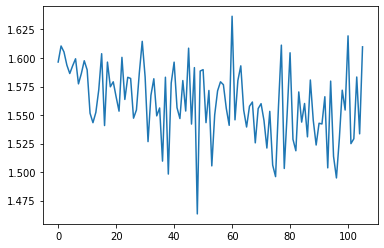

In [117]:
loss = torch.load('lossMaslowCNN')
plt.plot(loss[::10])
plt.show()

In [23]:
file = open('lossMaslowBERT', 'rb')
loss_maslow_bert = pickle.load(file)

[1.51266610622406, 1.4683917760849, 1.4606459140777588]

In [49]:
a = np.array([[1, 3], [1, 5], [1, 6]])
b = np.array([[2, 5], [2, 3], [2, 2]])

a = np.apply_along_axis(predict_one_hot, axis=1, arr=b)

a

array([[0, 1],
       [0, 1],
       [1, 0]])

In [74]:
def practice(x):
    sum = np.sum(np.rint(x))
    if sum == 0:
        z = np.zeros(x.shape, x.dtype)
        z[np.argmax(x)] = 1
        return z
    return np.rint(x)


e = np.array([[0.3, 0.2, 0.3, 0.6],[0.1, 0.2, 0.3, 0.2], [0.9, 0.5, 0.3, 0.2]])
np.apply_along_axis(practice, axis=1, arr=e)

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]])

In [119]:
c = np.load('test_run_4/labels_bert_maslow.npy')
d = np.load('test_run_4/preds_bert_maslow.npy')
precision_recall_fscore_support(c, d)

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.23005796, 0.22573077, 0.        , 0.27647504, 0.28329049]),
 array([0.84106963, 1.        , 0.        , 0.35974409, 0.98780925]),
 array([0.36129172, 0.36832031, 0.        , 0.31266039, 0.44030686]),
 array([1982, 2309, 1165, 2032, 2789]))